In [99]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [100]:
%matplotlib inline

In [101]:
from relaxed.plot_defaults import *

In [102]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split



In [103]:
from relaxed.analysis import setup, get_quantiles, gaussian_conditional, get_am, get_an_from_am, get_lam, get_ma, get_gradient, get_fractional_tdyn

# Data

In [41]:
# catalog
hcat, indices, scales = setup('m11', path='../../output')

# get ma 
ma = get_ma(hcat.cat, indices)

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../output')

Text(0.5, 0, '\\rm index')

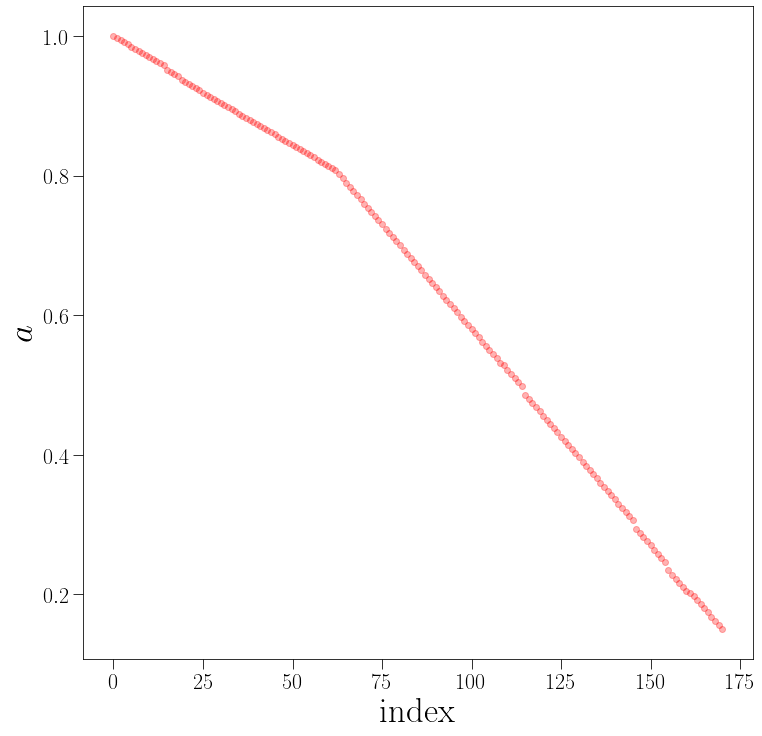

In [42]:
plt.figure(figsize=(12, 12))
plt.plot(scales, 'ro', alpha=0.3)
plt.ylabel(r"$a$", size=35)
plt.xlabel(r"\rm index", size=35)
# notice change in spacing below

# Calculate gradients

## numpy

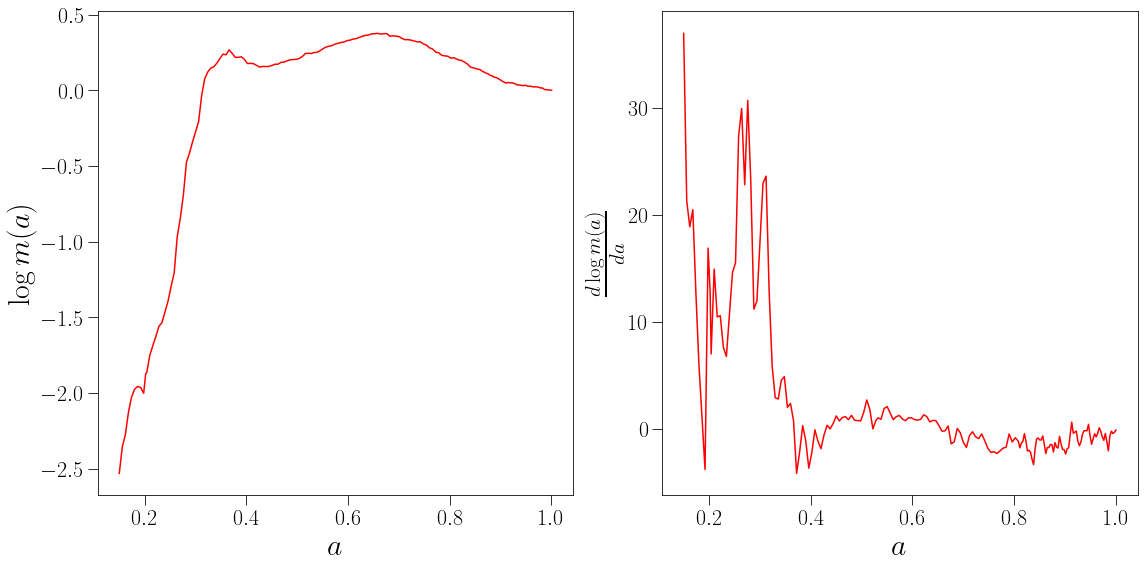

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
idx = 0
x = scales
grad = np.gradient(np.log(ma[idx, :]), x, edge_order=2)
ax1.plot(x, np.log(ma[idx, :]), 'r-')
ax2.plot(x, grad, 'r-')

ax1.set_xlabel(r"$a$", size=30)
ax2.set_xlabel(r"$a$", size=30)

ax1.set_ylabel(r"$\log m(a)$", size=30)
ax2.set_ylabel(r"$\frac{d\log m(a)}{da}$", size=30)
plt.tight_layout()

## vary k 

In [119]:
scales

array([1.00035, 0.99735, 0.99435, 0.99135, 0.98835, 0.98535, 0.98235,
       0.97935, 0.97635, 0.97335, 0.97035, 0.96735, 0.96435, 0.96135,
       0.95835, 0.95235, 0.94935, 0.94635, 0.94335, 0.93735, 0.93435,
       0.93135, 0.92835, 0.92535, 0.92235, 0.91935, 0.91635, 0.91335,
       0.91035, 0.90735, 0.90435, 0.90135, 0.89835, 0.89535, 0.89235,
       0.88935, 0.88635, 0.88335, 0.88035, 0.87735, 0.87435, 0.87135,
       0.86835, 0.86535, 0.86235, 0.85935, 0.85635, 0.85335, 0.85035,
       0.84735, 0.84435, 0.84135, 0.83835, 0.83535, 0.83235, 0.82935,
       0.82635, 0.82335, 0.82035, 0.81735, 0.81435, 0.81135, 0.80835,
       0.80235, 0.79635, 0.79035, 0.78435, 0.77835, 0.77235, 0.76635,
       0.76035, 0.75435, 0.74835, 0.74235, 0.73635, 0.73035, 0.72435,
       0.71835, 0.71235, 0.70635, 0.70035, 0.69435, 0.68835, 0.68235,
       0.67635, 0.67035, 0.66435, 0.65835, 0.65235, 0.64635, 0.64035,
       0.63435, 0.62835, 0.62235, 0.61635, 0.61035, 0.60435, 0.59835,
       0.59235, 0.58

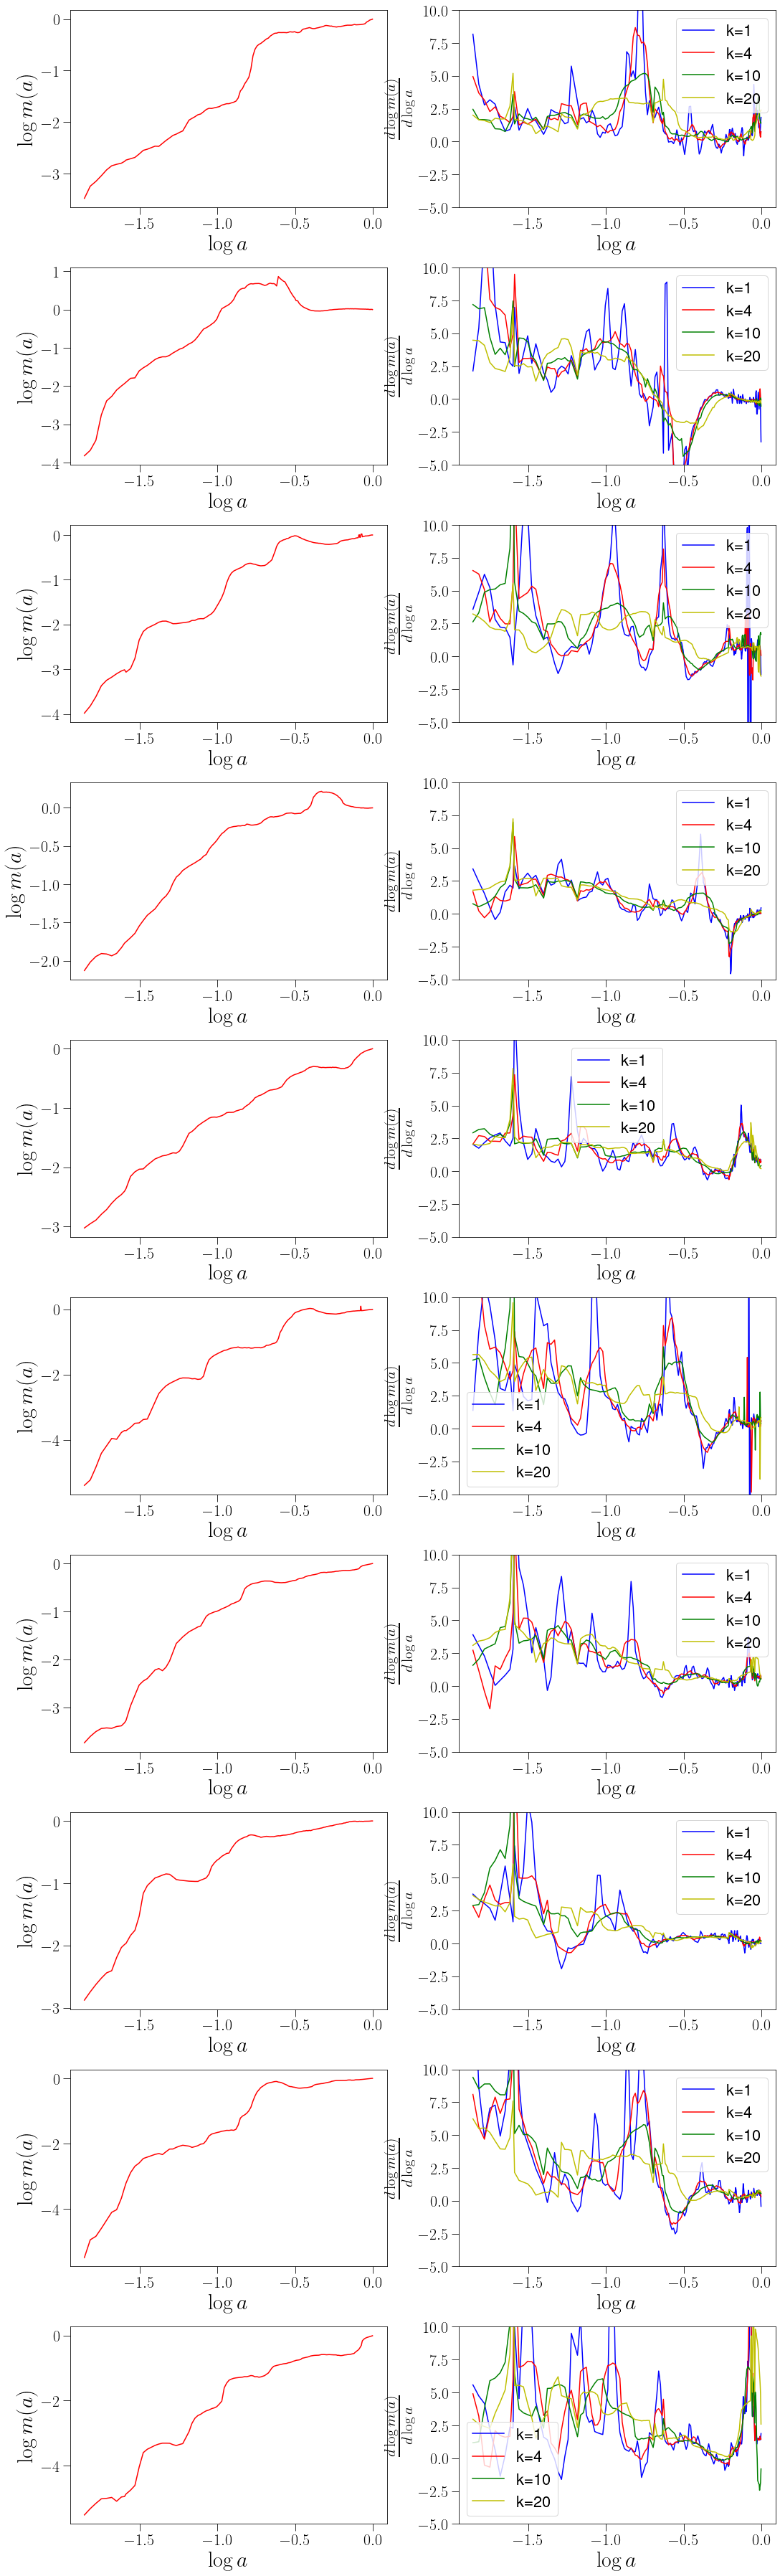

In [112]:
fig, axes = plt.subplots(10, 2, figsize=(15, 50))
indices = np.random.randint(0, len(ma), 10)
ks = [1, 4, 10, 20]
colors = ['b', 'r', 'g', 'y', 'm']
x = np.log(scales)

for i, idx in enumerate(indices): 
    ax1, ax2 = axes[i, :]
    ax1.plot(x, np.log(ma[idx, :]), 'r-')
    
    for c,k in zip(colors, ks): 
        grad = get_gradient(np.log(ma[[idx], :]), x, k=k)
        ax2.plot(x, grad[0], f'{c}-', label=f"k={k}")


    ax2.set_ylim(-5, 10)
    ax1.set_xlabel(r"$\log a$", size=30)
    ax2.set_xlabel(r"$\log a$", size=30)


    ax1.set_ylabel(r"$\log m(a)$", size=30)
    ax2.set_ylabel(r"$\frac{d\log m(a)}{d \log a}$", size=30)
    ax2.legend(loc='best')
plt.tight_layout()

## Fix k, vary accuracy

In [45]:
idx = np.random.randint(len(ma))

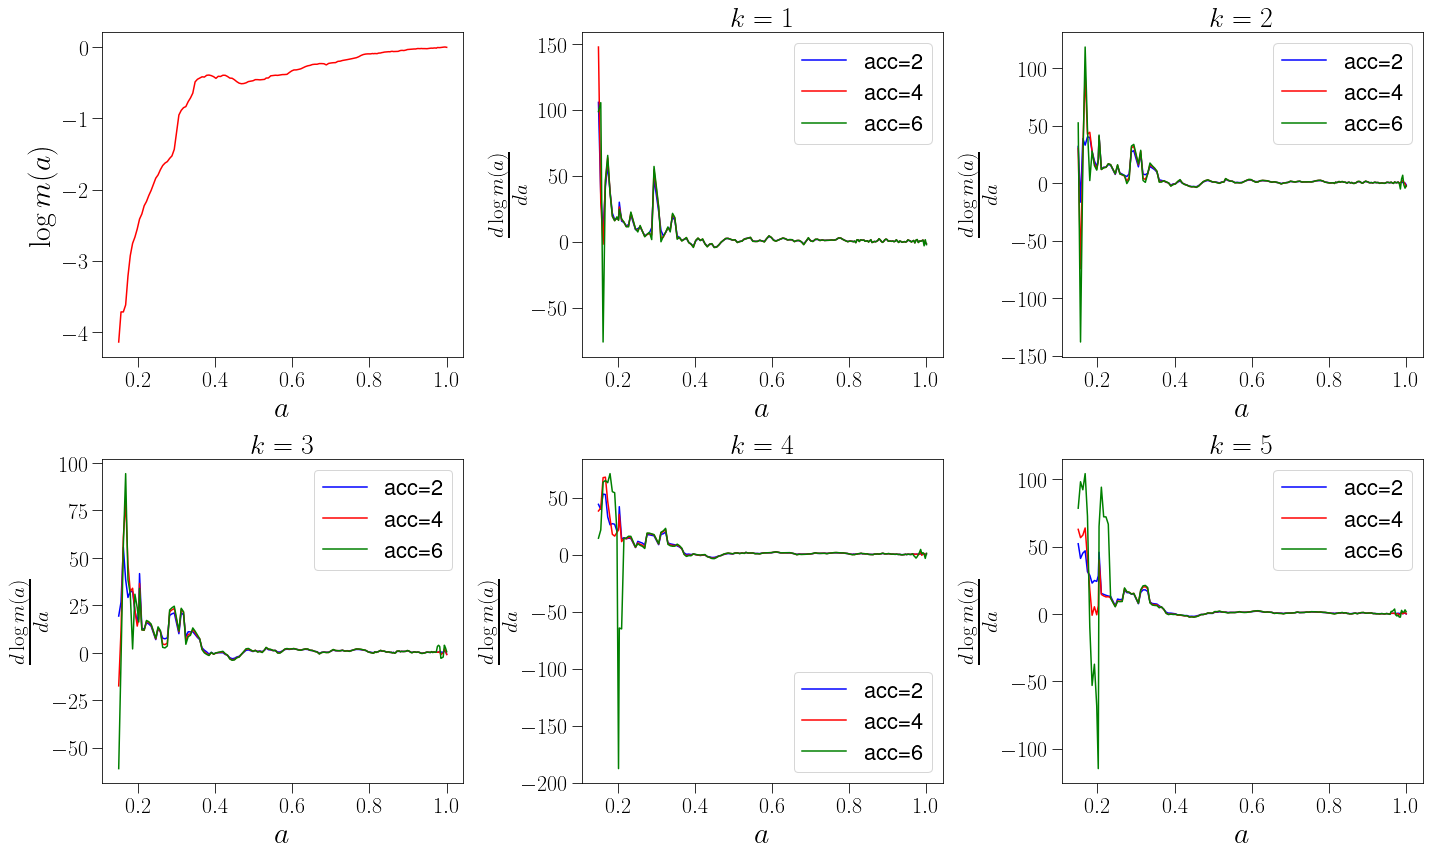

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
ax1 = axes[0]
axs = axes[1:]
x = scales
ks = [1,2,3,4,5]
accs = [2, 4, 6]
colors = ['b', 'r', 'g']
ax1.plot(x, np.log(ma[idx, :]), 'r-')
for k, ax in zip(ks, axs): 
    for c, acc in zip(colors, accs): 
        grad = get_gradient(np.log(ma[[idx], :]), x, k=k, acc=acc)
        ax.plot(x, grad[0], f'{c}-', label=f"acc={acc}")
    ax.set_xlabel(r"$a$", size=30)
    ax.set_ylabel(r"$\frac{d\log m(a)}{da}$", size=30)
    ax.legend(loc='best')
    ax.set_title(fr"$k={k}$")
    
ax1.set_xlabel(r"$a$", size=30)
ax1.set_ylabel(r"$\log m(a)$", size=30)
plt.tight_layout()

# Correlation between gradients and cvir, xoff, t/u

In [79]:
names = ['m11', 'm12']
params = ['cvir', 'x0', 't/|u|']
latex_params = ['c_{\\rm vir}', 'x_{\\rm off}', 't/|u|']
colors = ['r','b', 'g']
markers = np.array(['.', 'x'])

In [127]:
np.sum(np.isnan(grads[:, -10]))

80

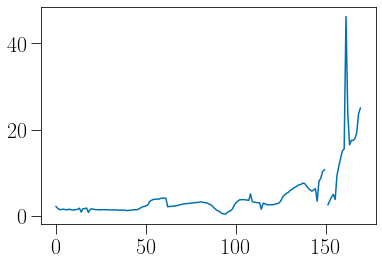

In [128]:
plt.plot(grads[9, :])


0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
3
3
4
4
4
4
5
5
5
5
5
5
5
5
5
6
6
7
7
7
9
9
9
9
9
9
9
9
9
10
11
12
12
13
13
13
15
16
16
21
22
24
27
31
32
34
37
41
51
56
61
69
80
87
97
107
130
170
195
230
272
318
385
405
461
568
687
829
1027
1269
1573
1976
2448
3040
1573
1976
2448
3040


/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:173: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
3
3
3
3
3
3
3
3
3
3
4
5
5
5
5
5
5
5
5
5
5
5
7
8
8
8
10
13
15
18
19
25
33
43
51
59
68
72
80
91
110
140
183
233
303
389
515
699
303
389
515
699


/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:173: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1



1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
3
3
4
4
4
4
5
5
5
5
5
5
5
5
5
6
6
7
7
7
9
9
9
9
9
9
9
9
9
10
11
12
12
13
13
13
15
16
16
21
22
24
27
31
32
34
37
41
51
56
61
69
80
87
97
107
130
170
195
230
272
318
385
405
461
568
687
829
1027
1269
1573
1976
2448
3040
461
568
687
829
1027
1269
1573
1976
2448
3040


/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:173: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
3
3
3
3
3
3
3
3
3
3
4
5
5
5
5
5
5
5
5
5
5
5
7
8
8
8
10
13
15
18
19
25
33
43
51
59
68
72
80
91
110
140
183
233
303
389
515
699
80
91
110
140
183
233
303
389
515
699


/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:173: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1



1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
3
3
4
4
4
4
5
5
5
5
5
5
5
5
5
6
6
7
7
7
9
9
9
9
9
9
9
9
9
10
11
12
12
13
13
13
15
16
16
21
22
24
27
31
32
34
37
41
51
56
61
69
80
87
97
107
130
170
195
230
272
318
385
405
461
568
687
829
1027
1269
1573
1976
2448
3040
97
107
130
170
195
230
272
318
385
405
461
568
687
829
1027
1269
1573
1976
2448
3040


/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:173: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
3
3
3
3
3
3
3
3
3
3
4
5
5
5
5
5
5
5
5
5
5
5
7
8
8
8
10
13
15
18
19
25
33
43
51
59
68
72
80
91
110
140
183
233
303
389
515
699
15
18
19
25
33
43
51
59
68
72
80
91
110
140
183
233
303
389
515
699


/Users/imendoza/code/nbody-relaxed/relaxed/analysis.py:173: RuntimeWarning: divide by zero encountered in true_divide
  z = (1 / scale) - 1


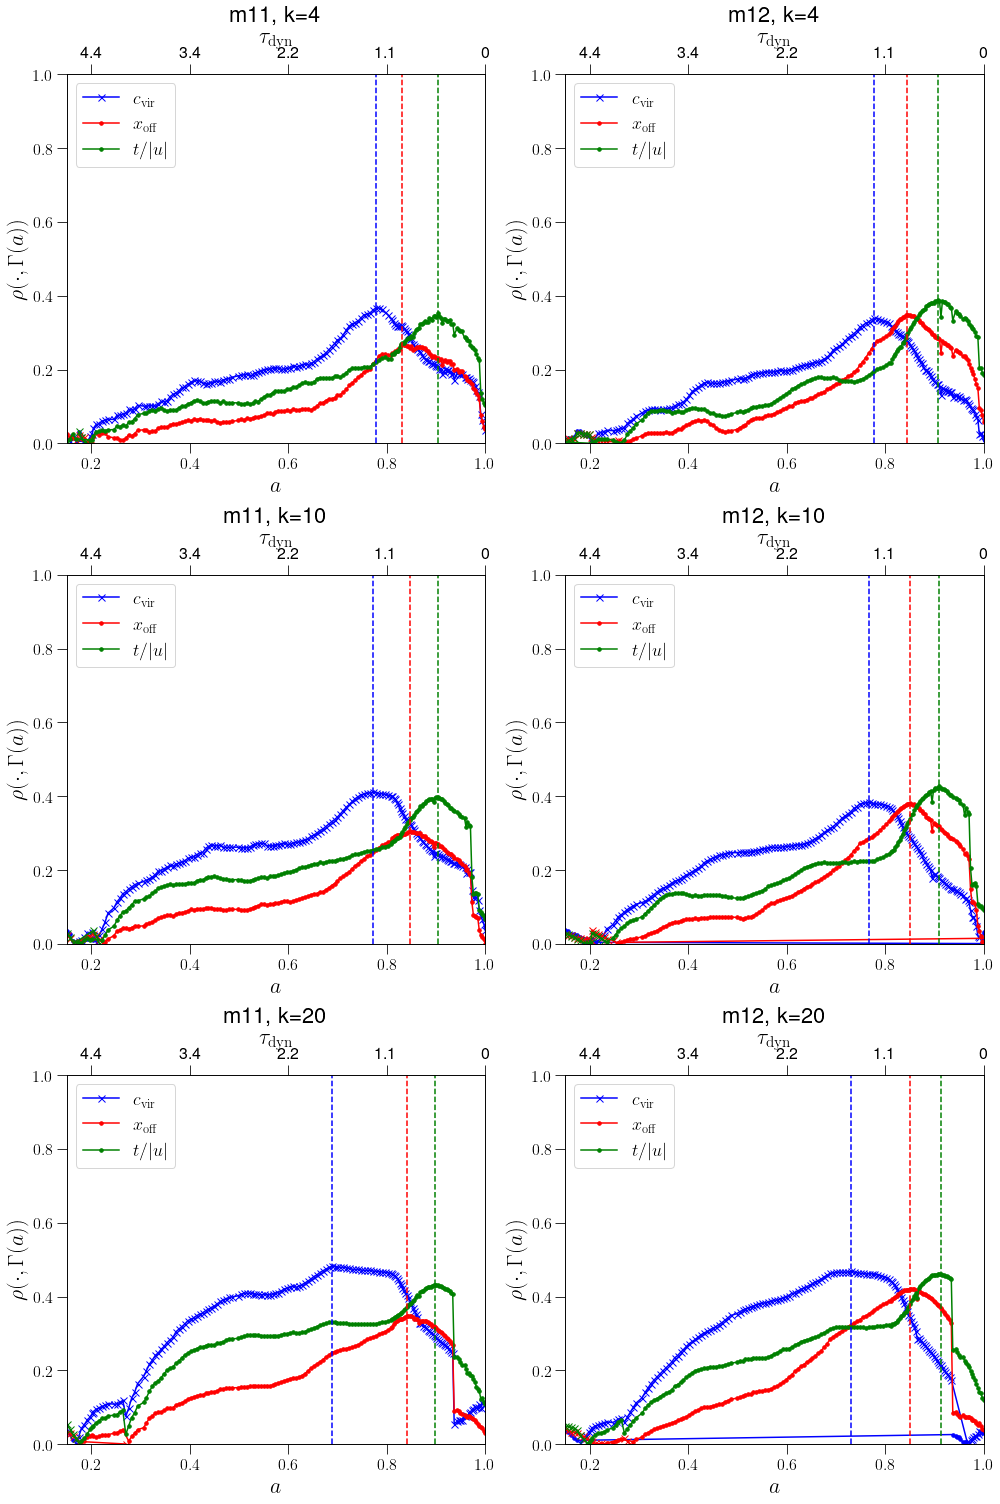

In [115]:
ks = [4, 10, 20]
fig, axes = plt.subplots(len(ks), len(names),figsize=(len(names)*7,7*len(ks)))
for p, k in enumerate(ks):
    for i, name in enumerate(names):
        hcat, indices, scales = setup(name)
        
        ma = get_ma(hcat.cat, indices)
        ax = axes[p, i]
        max_scales = [0.]*len(params)
        tdyn = np.mean(hcat.cat['tdyn']) / 10**9 #Gyr which astropy also returns by default
        grads = get_gradient(np.log(ma), scales, k=k, acc=2)
        
        
        for j, param in enumerate(params):
            latex_param = latex_params[j]
            color = colors[j]
            param_values = hcat.cat[param]

            # get correlations
            corrs = []
            for s in range(len(scales)):
                corrs.append(stats.spearmanr(param_values, grads[:,s], nan_policy="omit")[0])
            corrs = np.array(corrs)

            pos = corrs > 0 
            neg = ~pos
            corrs = abs(corrs)

            # plot positive corr and negative corr with different markers. 
            if sum(pos) > 0:
                label = f'${latex_param}$' if sum(pos) > sum(neg) else None
                ax.plot(scales[pos], corrs[pos], color=color, marker=markers[0], label=label, markersize=7)

            if sum(neg) > 0:
                label = f'${latex_param}$' if sum(pos) < sum(neg) else None
                ax.plot(scales[neg], corrs[neg], color=color, marker=markers[1], label=label, markersize=7)

            max_scales[j] = scales[np.nanargmax(abs(corrs))]


        # draw a vertical line at max scales
        for j, s in enumerate(max_scales):
            color = colors[j]
            ax.axvline(s, linestyle='--', color=color)


        ax.set_ylim(0, 1.0)
        ax.set_xlim(0, 1.0)
        ax.set_title(f"{name}, k={k}", size=22)
        ax.set_ylabel(f"$\\rho(\\cdot, \\Gamma(a))$", size=22)
        ax.set_xlabel(f"$a$", size=22)
        ax.tick_params(axis='both', which='major', labelsize=16)

        # add additional x-axis with tydn fractional scale
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(ax.get_xticks())

        fractional_tdyn = get_fractional_tdyn(ax.get_xticks(), tdyn, sim_name='Bolshoi')
        fractional_tdyn = np.array([f'{x:.2g}' for x in fractional_tdyn])
        ax2.set_xticklabels(fractional_tdyn, size=16)
        ax2.set_xlabel("$\\tau_{\\rm dyn}$", size=22)

        ax.legend(loc='best', prop={'size': 18})

        ax.set_xlim(0.15, 1)
        ax2.set_xlim(0.15 , 1)
plt.tight_layout()
plt.show()

## focus on one bin correlations

In [ ]:
ks = [4, 10, 20]
fig, axes = plt.subplots(len(ks), len(names),figsize=(len(names)*7,7*len(ks)))
for p, k in enumerate(ks):
    for i, name in enumerate(names):
        hcat, indices, scales = setup(name)
        
        ma = get_ma(hcat.cat, indices)
        ax = axes[p, i]
        max_scales = [0.]*len(params)
        tdyn = np.mean(hcat.cat['tdyn']) / 10**9 #Gyr which astropy also returns by default

        for j, param in enumerate(params):
            latex_param = latex_params[j]
            color = colors[j]
            param_values = hcat.cat[param]
            grads = get_gradient(np.log(ma), scales, k=k, acc=2)

            # get correlations
            corrs = []
            for s in range(len(scales)):
                corrs.append(stats.spearmanr(param_values, grads[:,s], nan_policy="omit")[0])
            corrs = np.array(corrs)

            pos = corrs > 0 
            neg = ~pos
            corrs = abs(corrs)

            # plot positive corr and negative corr with different markers. 
            if sum(pos) > 0:
                label = f'${latex_param}$' if sum(pos) > sum(neg) else None
                ax.plot(scales[pos], corrs[pos], color=color, marker=markers[0], label=label, markersize=7)

            if sum(neg) > 0:
                label = f'${latex_param}$' if sum(pos) < sum(neg) else None
                ax.plot(scales[neg], corrs[neg], color=color, marker=markers[1], label=label, markersize=7)

            max_scales[j] = scales[np.nanargmax(abs(corrs))]


        # draw a vertical line at max scales
        for j, s in enumerate(max_scales):
            color = colors[j]
            ax.axvline(s, linestyle='--', color=color)


        ax.set_ylim(0, 1.0)
        ax.set_xlim(0, 1.0)
        ax.set_title(f"{name}, k={k}", size=22)
        ax.set_ylabel(f"$\\rho(\\cdot, \\Gamma(a))$", size=22)
        ax.set_xlabel(f"$a$", size=22)
        ax.tick_params(axis='both', which='major', labelsize=16)

        # add additional x-axis with tydn fractional scale
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(ax.get_xticks())

        fractional_tdyn = get_fractional_tdyn(ax.get_xticks(), tdyn, sim_name='Bolshoi')
        fractional_tdyn = np.array([f'{x:.2g}' for x in fractional_tdyn])
        ax2.set_xticklabels(fractional_tdyn, size=16)
        ax2.set_xlabel("$\\tau_{\\rm dyn}$", size=22)

        ax.legend(loc='best', prop={'size': 18})

        ax.set_xlim(0.15, 1)
        ax2.set_xlim(0.15 , 1)
plt.tight_layout()
plt.show()